### Question: Does Clauset's method independently verify $M_z$?

We've established in another notebook that two metrics, the chi-square and SSI both pick $M_z$ from the space of possibilities as the best choice of sample size to arrive at the 2, 6, 12, 20, ... inverse pattern for n-legomena. These tests pick the _same_ $M_z$ as optimally fitting the TTR curve, but they both feel rather "ad hoc". After all, the 2-6-12-20-etc pattern is a secondary prediction of a Perfect Zipf Distribution, so testing for that doesn't exactly rule out confounding factors. What we'd like to do here is assert, using [Clauset's method](https://arxiv.org/pdf/0706.1062.pdf), that of the space of possible sample sizes $[0, M]$ that either:

- (a) $M_z$ is the sample size most closely power-law-distributed with parameter $\alpha = 1$ OR
- (b) $M_z$ is the sample size most closely power-law-distributed, period.

Should this be the case, should we find a "spike" or a "well" in the signal at this spot, then combined with the other two signals, this provides some pretty strong evidence that something magical happens at this point.

In [2]:
# bloody dependencies
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 16,8
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, LogModel

### Choosing a Book

Select a book for use as our fitting corpus.

Optimum = LogParams(M_z=173168, N_z=15857)


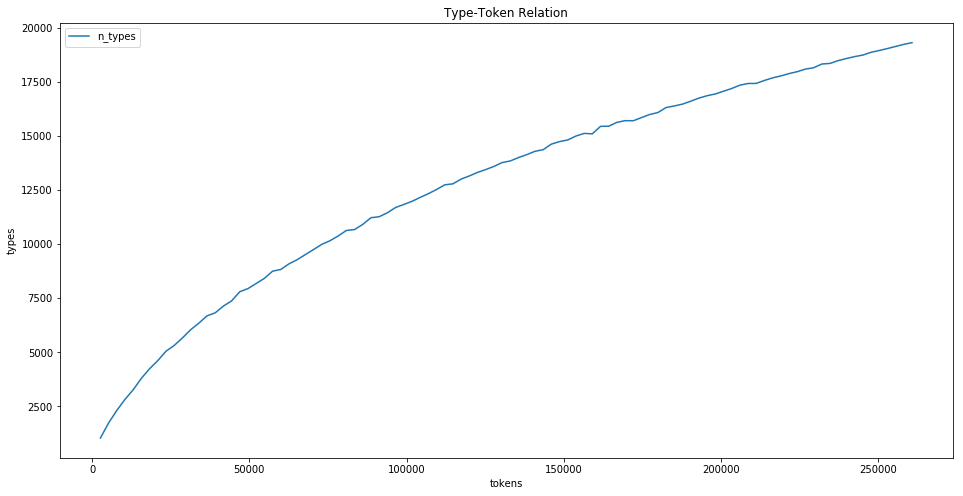

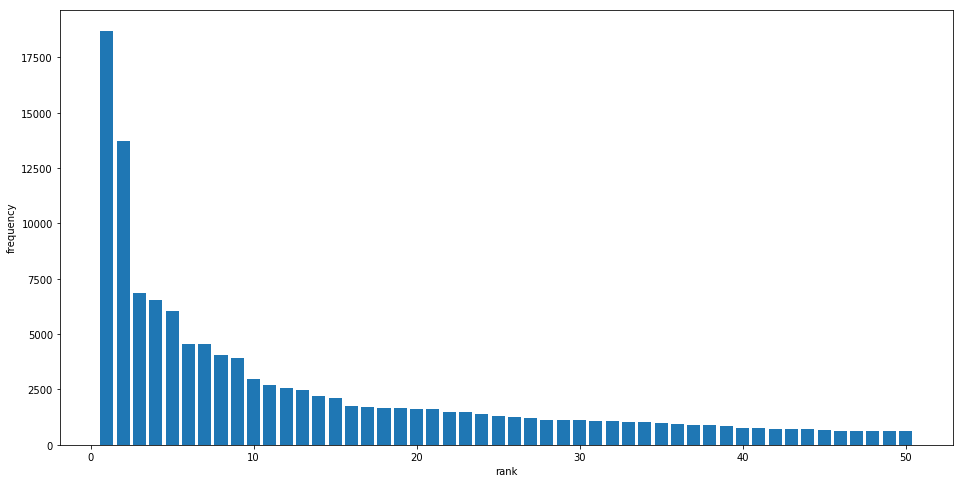

In [3]:
# moby dick
words = gutenberg.words("melville-moby_dick.txt")
corpus = Corpus(words)
TTR = corpus.TTR
m_tokens, n_types = TTR.m_tokens, TTR.n_types
model = LogModel().fit(m_tokens, n_types)
print("Optimum =", model.params)

# plot TTR curve
plt.plot(m_tokens, n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

# plot WFD
xmax = 50
df = corpus.fdist.copy().head(xmax)
plt.bar(df.index, df["freq"])
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

## What does an optimum sample look like?

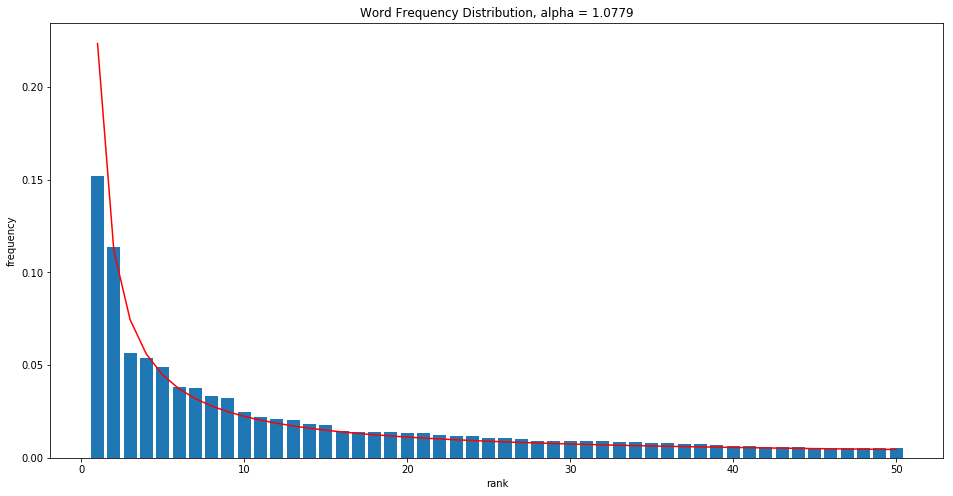

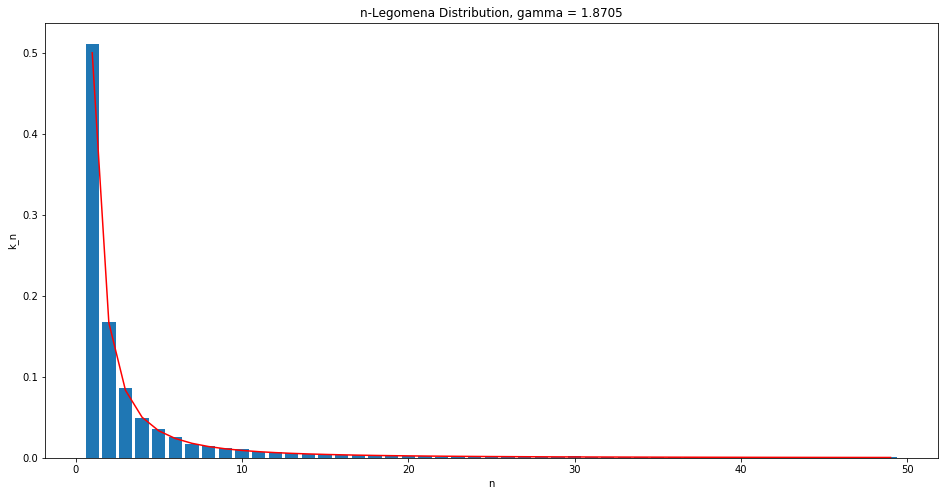

In [4]:
# take an optimum sample
corpus.seed = None
optimum = corpus.sample(model.M_z)
optimum.M, optimum.N

# plot WFD
xmax = 50
H = np.sum(1/np.arange(1,xmax))
df = optimum.fdist.copy().reset_index().head(xmax)
df["freq"] = df["freq"]/df["freq"].sum()
df["pred"] = 1/H/(df["rank"])
plt.bar(df["rank"], df["freq"])
plt.plot(df["rank"], df["pred"], color="red")
plt.title("Word Frequency Distribution, alpha = %0.4f" % optimum.alpha)
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot legomena
k = optimum.k[:xmax]
n = np.arange(1, len(k))
plt.bar(n, k[n]/sum(k))
plt.plot(n, 1/n/(n+1), color="red")
plt.title("n-Legomena Distribution, gamma = %0.4f" % optimum.gamma)
plt.xlabel("n")
plt.ylabel("k_n")
plt.show()

## Fake Zipfian Data

Here we take a brief vacation from our words data and instead use `numpy.random.zipf()` to generate some fake data instead. Indeed, it exhibits exactly the same pattern, bottoming out at a value somewhere around $\alpha = 1.75$.

In [5]:
from scipy.stats import chisquare
def ssi_test(f_obs, f_exp):
    assert all(f_obs >= 0)
    assert all(f_exp >= 0)
    nonzero = (f_obs > 0) & (f_exp > 0)
    f_obs = f_obs[nonzero]
    f_exp = f_exp[nonzero]
    f_obs = f_obs / f_obs.sum()
    f_exp = f_exp / f_exp.sum()
    return np.sum((f_obs - f_exp) * np.log(f_obs / f_exp))

M, n = 9999, 40
f_exp = np.array([1 / i / (i+1) for i in range(1, n) ])
print("Expected n-legomena proportions:", f_exp)
f_exp = M * f_exp
df = []
for _ in range(99):
    alpha = np.random.uniform(1.2, 2.5)
    x = np.random.zipf(a = alpha, size = M)
    f_obs = np.array([ sum(x == i) for i in range(1, n)])
    sse = np.sum((f_exp - f_obs)**2)
    ssi = ssi_test(f_obs, f_exp)
    df.append((alpha, sse, ssi))
    
df = pd.DataFrame(df, columns = ["alpha", "sse", "ssi"])
df.head()

Expected n-legomena proportions: [0.5        0.16666667 0.08333333 0.05       0.03333333 0.02380952
 0.01785714 0.01388889 0.01111111 0.00909091 0.00757576 0.00641026
 0.00549451 0.0047619  0.00416667 0.00367647 0.00326797 0.00292398
 0.00263158 0.00238095 0.0021645  0.00197628 0.00181159 0.00166667
 0.00153846 0.0014245  0.00132275 0.00123153 0.00114943 0.00107527
 0.00100806 0.00094697 0.00089127 0.00084034 0.00079365 0.00075075
 0.00071124 0.00067476 0.00064103]


,alpha,sse,ssi
0,1.303778,6.191315e+06,0.228072
1,1.570098,7.288127e+05,0.040003
2,2.365658,5.093392e+06,0.242645
3,1.996485,1.235776e+06,0.059682
4,2.136295,2.439051e+06,0.110838


## Enter Number Theory

This stability measure appears to minimize for a random Zipf variable $X \sim Z[\rho]$ for $\zeta(\rho) = 2, \rho = 1.7286472389981835$ [Kalmar's Constant](https://en.wikipedia.org/?title=Talk:L%C3%A1szl%C3%B3_Kalm%C3%A1r&oldid=514021658).

Why?

Zipf's original rank-frequency distribution suggests an exponent near 1. Why would an exponent much closer to 2 appear to give better results? I think I'm doing something wrong here. But anyway, as it stands, the hypothesis is: Given a random Zipfian variable with parameter $\alpha$, $X \sim Z[\alpha]$, the optimum choice for $\alpha$ to fit $Pr(X=n) = \frac{1}{n(n+1)}$ is $\alpha = \rho = 1.7286472389981835$, [Kalmar's Constant](https://en.wikipedia.org/?title=Talk:L%C3%A1szl%C3%B3_Kalm%C3%A1r&oldid=514021658).

In [6]:
# calculate rho
func = lambda x : zeta(x) - 2.
x0 = 1.75
rho = fsolve(func, x0)[0]

print("rho = ", rho)
print("zeta(rho) =", zeta(rho))

rho =  1.7286472389981835
zeta(rho) = 2.0000000000000004


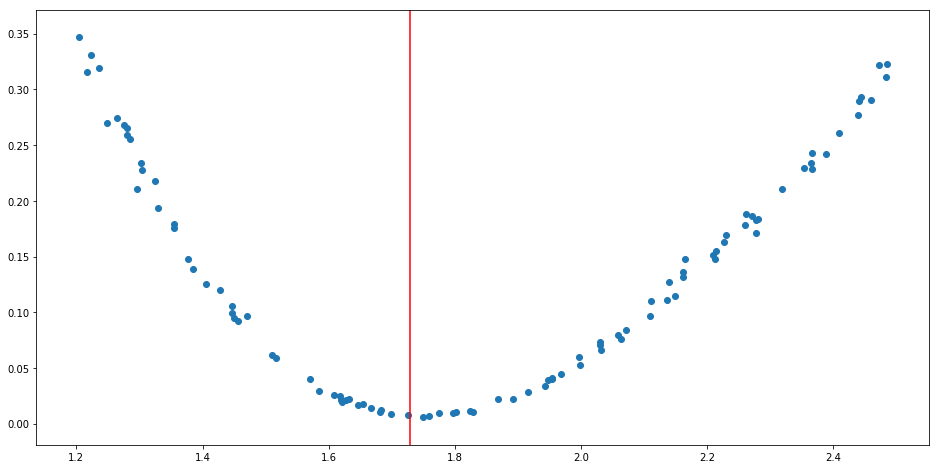

In [7]:
# visualization
plt.scatter(df.alpha, df.ssi)
plt.axvline(x = rho, color = 'r')
plt.show()

## n-Legomena from fake data

In fact, we can count hapaxes and higher $n$-legomena straight from this fake distribution, just by answering the question, what is $Pr(X = n)$ given Zipf's density function $p(x) = \frac{x^{-\alpha}}{\zeta(\alpha)}$?

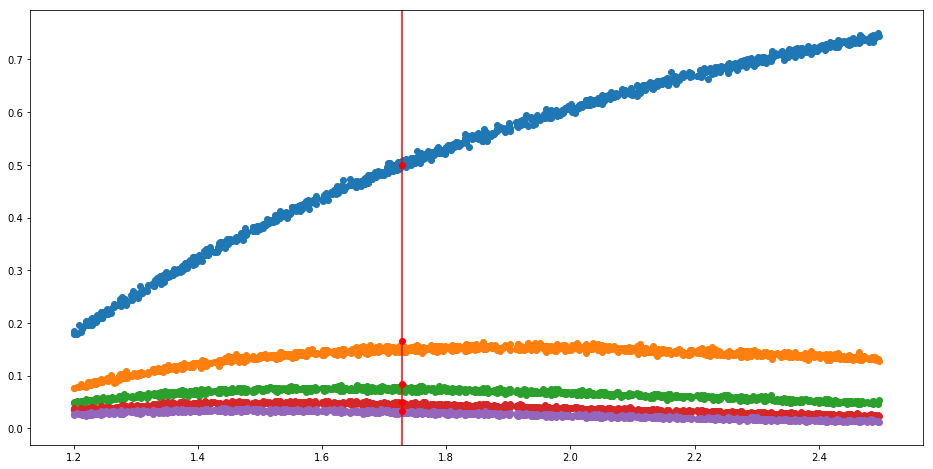

,alpha,hapax,dis,tris,tetra,penta
248,1.729416,0.506551,0.146415,0.075708,0.043404,0.030703
291,1.729810,0.508451,0.150715,0.072507,0.044804,0.028803
132,1.731102,0.499250,0.146015,0.076308,0.044804,0.031703
79,1.731622,0.499150,0.145015,0.075308,0.047805,0.031703
336,1.732101,0.502450,0.151615,0.079608,0.043804,0.029003


In [8]:
# count hapaxes from 3rd party zipf distribution
M, n = 9999, 9
df = []
for _ in range(999):
    alpha = np.random.uniform(1.2, 2.5)
    x = np.random.zipf(a = alpha, size = M)
    f_obs = np.array([ sum(x == i) for i in range(n)]) / M
    df.append((alpha, f_obs[1], f_obs[2], f_obs[3], f_obs[4], f_obs[5]))
    
df = pd.DataFrame(df, columns = ["alpha", "hapax", "dis", "tris", "tetra", "penta"])
df = df.sort_values("alpha")
df.head()

plt.scatter(df.alpha, df.hapax)
plt.scatter(df.alpha, df.dis)
plt.scatter(df.alpha, df.tris)
plt.scatter(df.alpha, df.tetra)
plt.scatter(df.alpha, df.penta)
plt.axvline(x = rho, color = 'r')
plt.scatter([rho, rho, rho, rho, rho], 1./np.array([2,6,12,20,30]), color = 'r')
plt.show()

df[df.alpha > rho].head()

## Clauset's Method

Let's first tie down Clauset's method by producing power-law data and seeing if it can indeed recover the exponent.

Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


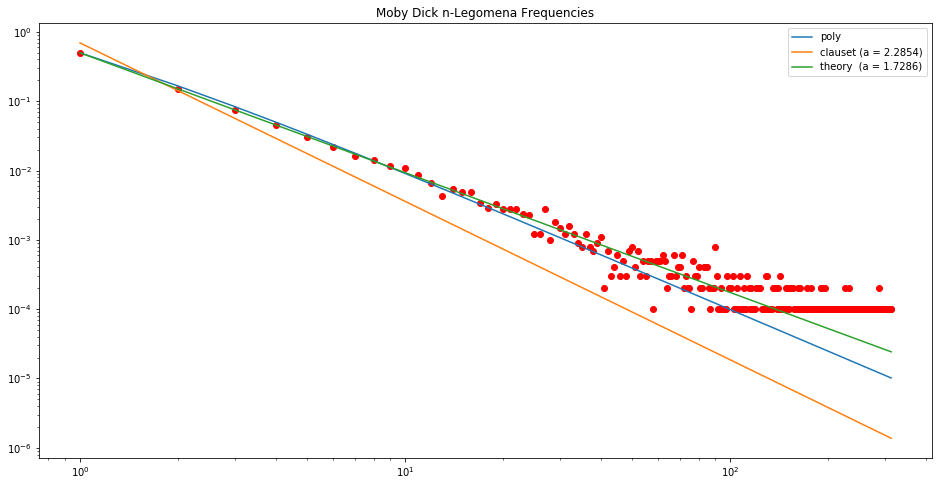

In [9]:
import powerlaw

# fake data
y = np.random.zipf(rho, 9999)
_, y = np.unique(y, return_counts = True) # group
dist = powerlaw.Fit(y).power_law
a_obs = dist.alpha
a_opt = rho

y = y / sum(y) # normalize
x = np.arange(1, len(y)+1)

y1 = 1/x/(x+1)               # model 1: k_n ~ 1/n/(n+1)
y2 = x**-a_obs / zeta(a_obs) # clauset: a ~ 2.09
y3 = x**-a_opt / zeta(a_opt) # theory: a = rho ~ 1.72

plt.scatter(x, y, color = 'r')
plt.plot(x, y1, label = "poly")
plt.plot(x, y2, label = f"clauset (a = {a_obs:0.4f})")
plt.plot(x, y3, label = f"theory  (a = {a_opt:0.4f})")
plt.loglog()
plt.title(f"Moby Dick n-Legomena Frequencies")
plt.legend()
plt.show()

Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


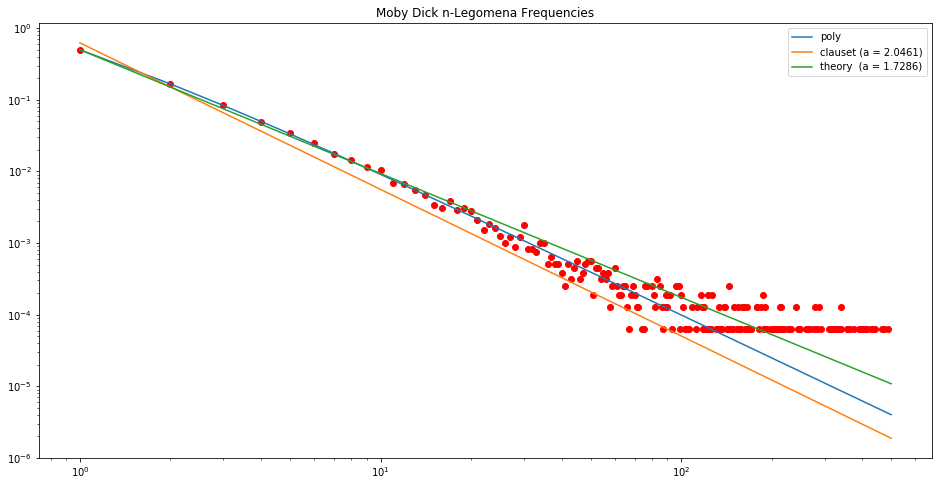

In [10]:
import powerlaw

data = optimum.fdist.freq.values
dist = powerlaw.Fit(data).power_law
a_obs = dist.alpha
a_opt = rho

y = optimum.k[1:500]
x = np.arange(1, len(y)+1)
y = y / sum(y) # normalize

y1 = 1/x/(x+1)               # model 1: k_n ~ 1/n/(n+1)
y2 = x**-a_obs / zeta(a_obs) # clauset: a ~ 2.09
y3 = x**-a_opt / zeta(a_opt) # theory: a = rho ~ 1.72

plt.scatter(x, y, color = 'r')
plt.plot(x, y1, label = "poly")
plt.plot(x, y2, label = f"clauset (a = {a_obs:0.4f})")
plt.plot(x, y3, label = f"theory  (a = {a_opt:0.4f})")
plt.loglog()
plt.title(f"Moby Dick n-Legomena Frequencies")
plt.legend()
plt.show()

## Conclusion

None, really. Clauset's method doesn't appear to choose a better exponent than the other two approximations, and the data are too noisy to obtain a robust result.